# Generative models

In [1]:
import torch
from torch import nn
from torch.nn import functional as F
import matplotlib.pyplot as plt
import numpy as np

## Auto-Encoder

Before creating generative models, let's first discuss a non-generative model called the Auto-Encoder (AE). The AE takes as an input some $X$ and tries to compress this input via the encoder part of the network. As a result, we can encode $X$ to get a latent variable $Z$. Then we decode the latent $Z$ to get a reconstruction of $X$, which we denote as $\tilde{X}$. The idea is to learn a mapping from the input to itself, i.e., we want to learn a function
$$
    f: X \rightarrow X
$$
Our learning objective is therefore to change the weights of both the encoder and the decoder such that $X \approx \tilde{X}$. In other words, we want our reconstructed $\tilde{X}$ to be as similar as possible to our original input $X$. After training the network in this way, we get a model that is able to compress its input into a (lower) dimensional space, which we denote as $Z$. Thus, we are not actually interested in the reconstructed input $\tilde{X}$, but rather, we are interested in learning how to encode the input $X$ and how to decode the latent $Z$.  

One key observation is that the latent space $Z$ is **not** probabilistic. Let's implement the AE to see why this is the case. We will be using the MNIST dataset again, and our encoder/decoder will consist of a stack of convolutional layers that sequentially learn to compress the input image $X$ into $Z$, and learn to upscale and transform the latent $Z$ into the reconstructed input $\tilde{X}$. 

For this, let's first write down the dimensions to get a good idea what the transformations will do to our input. 

Input to the **encoder** has the shape `(batch_size, channels, height, width)`. In the case of MNIST, we are working with black-white images of $28 \times 28$. In this example, the MNIST images are first resized so that they are $32 \times 32$. In each convolutional layer, we increase the amount of output channels, while halving both the height and the width of the input image. This is laid out in the following steps: 
1. `(batch_size, 1, 32, 32)`
2. `(batch_size, 64, 16, 16)`
3. `(batch_size, 128, 8, 8)`
4. `(batch_size, 256, 4, 4)`
5. `(batch_size, z_size, 1, 1)`

Notice that from the 4th to the 5th layer, we actually transform 256 channels that are each $4\times 4$ into `z_size` channels that are each $1\times 1$. In other words, the variable `z_size` dictates how many dimensions our latent space has.  

Input to the **decoder** has the shape `(batch_size, z_size, 1, 1)`. To decode the latent variable back into an image, we apply the transformations of the encoder in reverse order:
1. `(batch_size, z_size, 1, 1)`
2. `(batch_size, 256, 4, 4)`
3. `(batch_size, 128, 8, 8)`
4. `(batch_size, 64, 16, 16)`
5. `(batch_size, 1, 32, 32)`

Notice how playing around with the `kernel_size`, `stride`, and `padding` parameters of the `nn.Conv2d` layer can decrease the dimensionality of the input image. Also notice that to increase the dimensionality in the decoder part, we need to use `nn.ConvTranspose2d` layers, which create new features instead of reducing the features in the input. See image below for a visual representation of transposed convolutional layers.

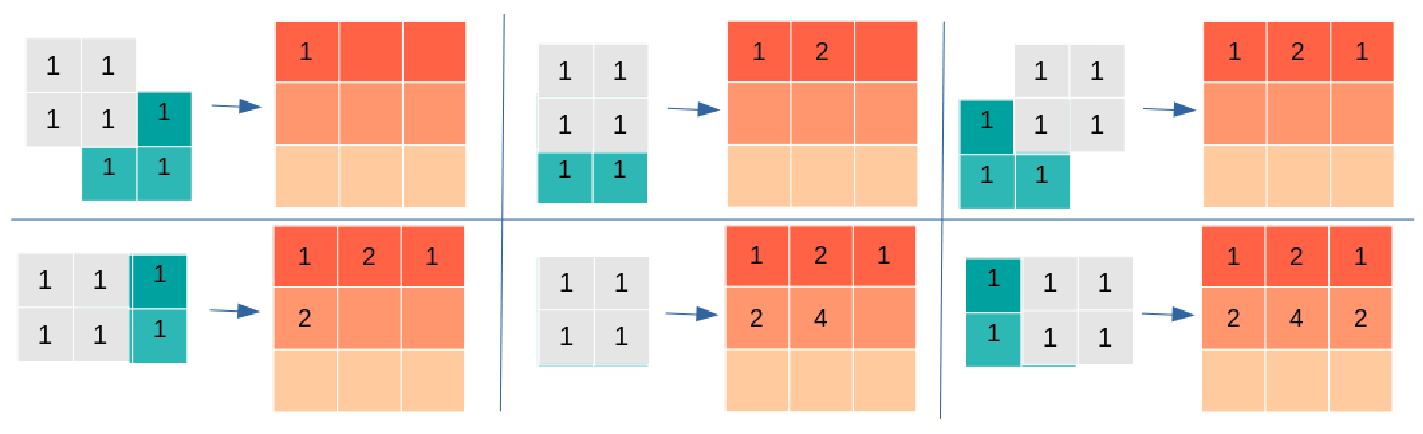

*Read more about transposed convolutional layers here: https://stackoverflow.com/questions/68976745/in-keras-what-is-the-difference-between-conv2dtranspose-and-conv2d*

In [3]:
class Encoder(nn.Module):
    def __init__(self, z_size=2):
        super().__init__()
        self.z_size = z_size
        self.net = nn.Sequential(
            # 32 -> 16
            nn.Conv2d(1, 64, kernel_size=3, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(64, affine=True),
            nn.ReLU(inplace=True),
            # 16 -> 8
            nn.Conv2d(64, 128, kernel_size=3, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(128, affine=True),
            nn.ReLU(inplace=True),
            # 8 -> 4
            nn.Conv2d(128, 256, kernel_size=3, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(256, affine=True),
            nn.ReLU(inplace=True),
            # 4 -> 1
            nn.Conv2d(256, z_size, kernel_size=3, stride=2, padding=0, bias=False),
        )
    
    def forward(self, X: torch.Tensor):
        return self.net(X)

class Decoder(nn.Module):
    def __init__(self, z_size=2):
        super().__init__()
        self.z_size = z_size
        self.net = nn.Sequential(
            # 1 -> 4
            nn.ConvTranspose2d(z_size, 256, kernel_size=4, stride=1, padding=0, bias=False),
            nn.BatchNorm2d(256, affine=True),
            nn.ReLU(inplace=True),
            # 4 -> 8
            nn.ConvTranspose2d(256, 128, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(128, affine=True),
            nn.ReLU(inplace=True),
            # 8 -> 16
            nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(64, affine=True),
            nn.ReLU(inplace=True),
            # 16 -> 32
            nn.ConvTranspose2d(64, 1, kernel_size=4, stride=2, padding=1, bias=False),
        )

    def forward(self, X: torch.Tensor):
        return self.net(X)
    
    
class AutoEncoder(nn.Module):
    def __init__(self, z_size=2):
        super().__init__()
        self.enc = Encoder(z_size)
        self.dec = Decoder(z_size)

    def forward(self, X: torch.Tensor):
        z = self.enc(X)
        y = self.dec(z)
        return y, z

# let's test it out on some random input
x = torch.randn(64, 1, 32, 32)
generator = AutoEncoder(z_size=20)
y, z = generator(x)
y.shape, z.shape

(torch.Size([64, 1, 32, 32]), torch.Size([64, 20, 1, 1]))

### Training Auto-Encoder

For the training regime, we split the MNIST dataset in train/test/validation sets according to a 60000/5000/5000 distribution.   

In [22]:
# Training constants
EPOCHS = 20
BATCH_SIZE = 256
LEARNING_RATE = 0.03
LEARNING_RATE_GAMMA = 0.9

# Model constants
Z_DIM = 2

# check for possible GPU usage
DEVICE = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

In [23]:
import torchvision
import torchvision.transforms as transforms

# define preprocessing transformations to dataset
transform = transforms.Compose([
    transforms.Resize(32),
    # transforms.Normalize((0.5,), (0.5,)),
    transforms.ToTensor(),
])

# load training set
train_set = torchvision.datasets.MNIST(root="../datasets", train=True, download=True, transform=transform)

# load test/validation set
test_val_set = torchvision.datasets.MNIST(root="../datasets", train=False, download=True, transform=transform)

# split into separate test and validation sets
X_test_val, y_test_val = zip(*test_val_set)
X_test_val = torch.stack(X_test_val)
y_test_val = torch.tensor(y_test_val)

test_idx, val_idx = torch.utils.data.random_split(y_test_val, [5000, 5000])

X_test = X_test_val[test_idx.indices]
y_test = y_test_val[test_idx.indices]

X_val = X_test_val[val_idx.indices]
y_val = y_test_val[val_idx.indices]

(train_set.data.shape, train_set.targets.shape, X_test.shape, y_test.shape, X_val.shape, y_val.shape)

(torch.Size([60000, 28, 28]),
 torch.Size([60000]),
 torch.Size([5000, 1, 32, 32]),
 torch.Size([5000]),
 torch.Size([5000, 1, 32, 32]),
 torch.Size([5000]))

Some important training considerations are the following. Adam optimizer is used, as it generally performs better than standard SGD. We introduce a learning rate scheduler, which updates the learning rate after each epoch according to some scheme. In this case, the learning rate is exponentially decayed by a `gamma` value which we set at 0.9. 

For the loss, we use the Binary Cross-Entropy with logits loss. Since our MNIST imageset is normalized to be in the range $[0, 1]$, we would ideally apply a sigmoid layer at the end of the decoder so that our reconstruction also lies within the range $[0, 1]$. However, in this case, for numeric stability, we did not include the sigmoid layer. Instead we can regard our outputs as "pre-sigmoid" outputs, which we often just call **logits** (speak: "lodzjits"). The `BCEWithLogitsLoss` implicitly applies a numerically stable sigmoid and calculates the BCE loss. Alternatives would be the use of the MSE loss. However, the nice property of the BCE is that reconstruction mistakes are penalized more harshly, leading to gradients that are a bit bigger than the gradients produced by the MSE loss.  

Notice that when we test our trained model against the test set, that we maintain the latent $Z$ variable, so that we can visualize its contents next.  

In [24]:
train_loader = torch.utils.data.DataLoader(train_set, batch_size=BATCH_SIZE, shuffle=True)

generator = AutoEncoder(z_size=Z_DIM).to(DEVICE)

optimizer = torch.optim.Adam(generator.parameters(), lr=LEARNING_RATE)
scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=LEARNING_RATE_GAMMA)
criterion = nn.BCEWithLogitsLoss()

train_history = []
val_history = []

for epoch in range(EPOCHS):
    batch_history = []
    for i, (images, _) in enumerate(train_loader):
        images = images.to(DEVICE)
        # predict and compute loss
        preds, _ = generator(images)
        loss = criterion(preds, images)
        batch_history.append(loss.item())
        # optimization step
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    
    # update learning rate
    scheduler.step()
    
    train_history.append(torch.mean(torch.tensor(batch_history)))

    with torch.no_grad():
        preds, _ = generator(X_val.to(DEVICE))
        loss = criterion(preds, X_val.to(DEVICE))
        val_history.append(loss.item())
    
    print(f"epoch {epoch}, train_loss {train_history[-1]}, val_loss {val_history[-1]}")


# TEST
with torch.no_grad():
    preds, z = generator(X_test.to(DEVICE))
    loss = criterion(preds, X_test.to(DEVICE))
    print(f"test_loss {loss.item()}")

epoch 0, train_loss 0.2527860105037689, val_loss 0.2226559966802597
epoch 1, train_loss 0.21647174656391144, val_loss 0.2128717303276062
epoch 2, train_loss 0.2080543488264084, val_loss 0.20372621715068817
epoch 3, train_loss 0.20385664701461792, val_loss 0.2010391503572464
epoch 4, train_loss 0.20164801180362701, val_loss 0.19801898300647736
epoch 5, train_loss 0.1994008868932724, val_loss 0.19822505116462708
epoch 6, train_loss 0.1976625770330429, val_loss 0.19613860547542572
epoch 7, train_loss 0.19686710834503174, val_loss 0.19491049647331238
epoch 8, train_loss 0.19548925757408142, val_loss 0.19602113962173462
epoch 9, train_loss 0.19422684609889984, val_loss 0.1930544525384903
epoch 10, train_loss 0.19386298954486847, val_loss 0.19230832159519196
epoch 11, train_loss 0.19327221810817719, val_loss 0.19285500049591064
epoch 12, train_loss 0.19213353097438812, val_loss 0.19189909100532532
epoch 13, train_loss 0.19157467782497406, val_loss 0.1920979917049408
epoch 14, train_loss 0.19

### Visualize training procedure and latent $Z$-space

Using the latent $Z$ variable whose values are produced by the test set, we can visualize the $Z$ latent variable (since we set its dimensionality to be two). 

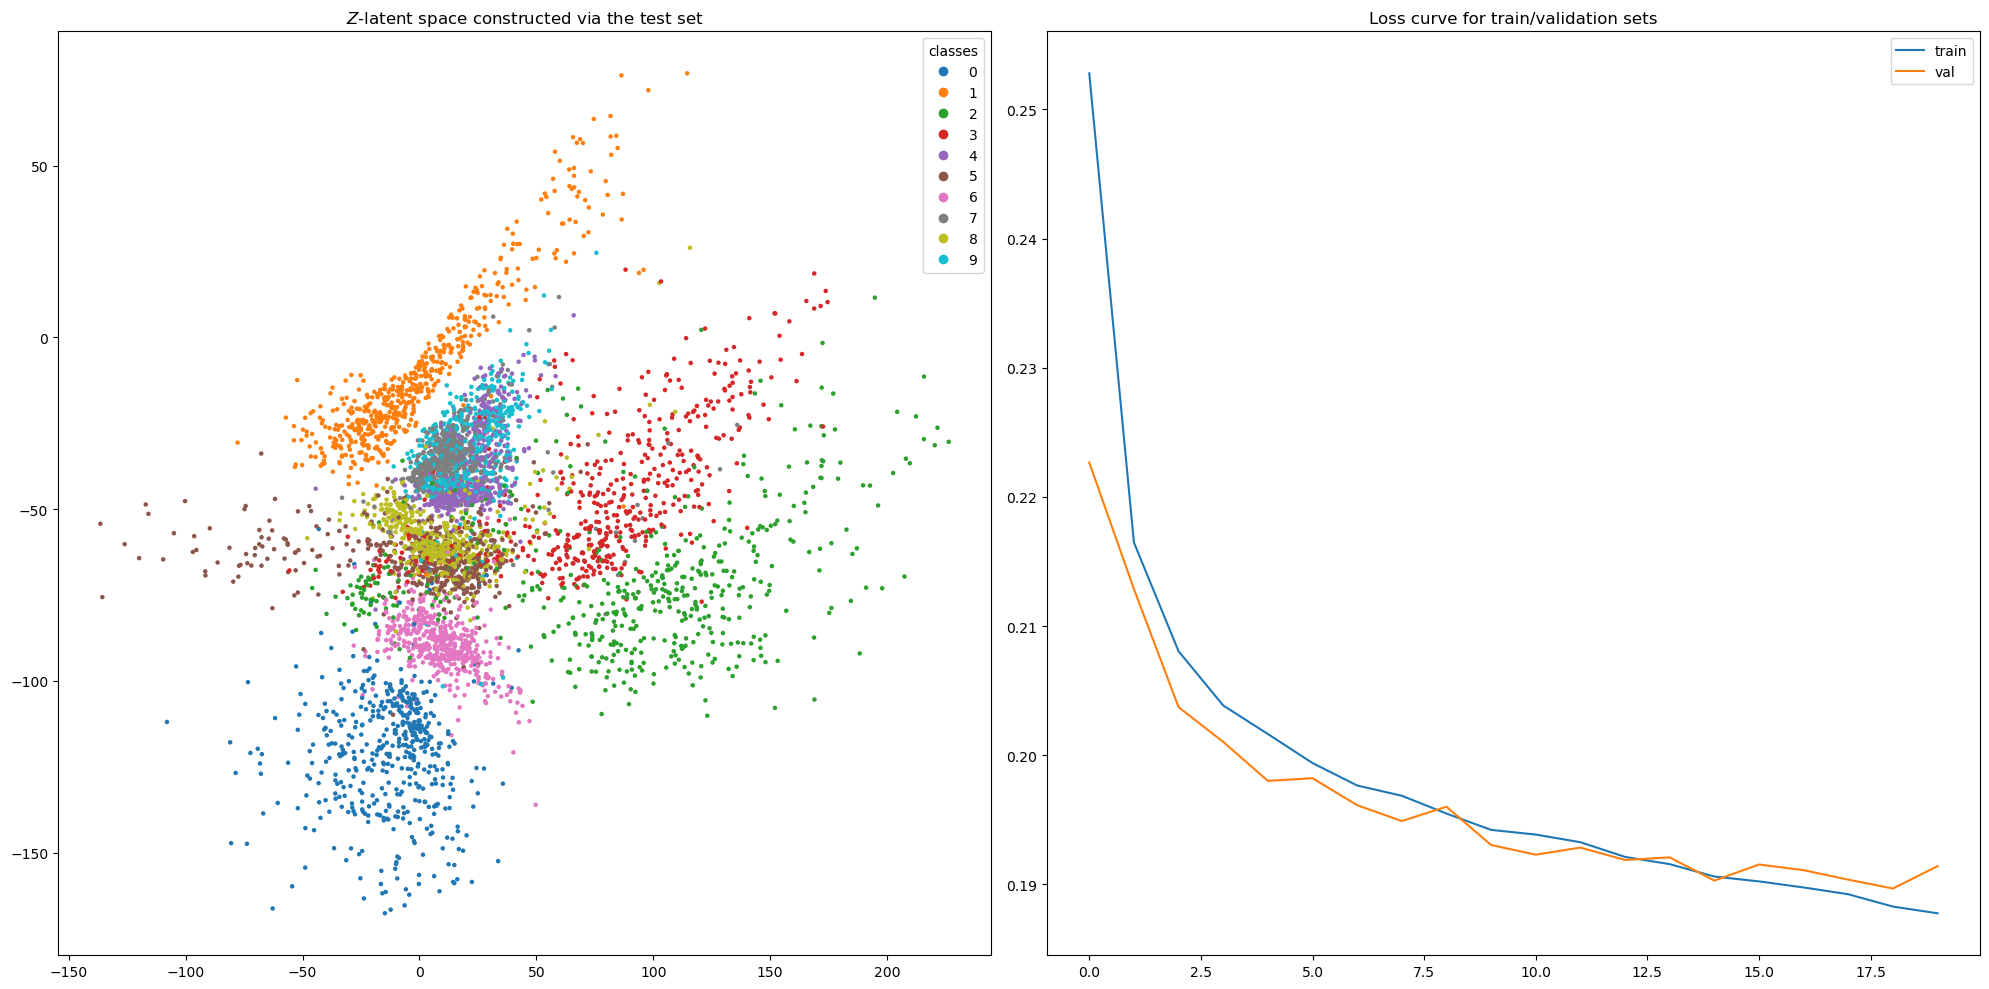

In [25]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 10))

z = z.squeeze().cpu().detach()
sc = ax1.scatter(z[:, 0], z[:, 1], c=y_test, s=5, cmap='tab10')
ax1.legend(*sc.legend_elements(), title='classes')
ax1.set_title("$Z$-latent space constructed via the test set")

ax2.plot(train_history, label="train")
ax2.plot(val_history, label="val")
ax2.legend()
ax2.set_title("Loss curve for train/validation sets")

plt.tight_layout()

### Generating samples

Now that we have trained an Auto-Encoder, we can take random samples and see how they get reconstructed by the AE. Notice that we applied a sigmoid to the predictions since we assumed that the model outputs pre-sigmoid logits. 

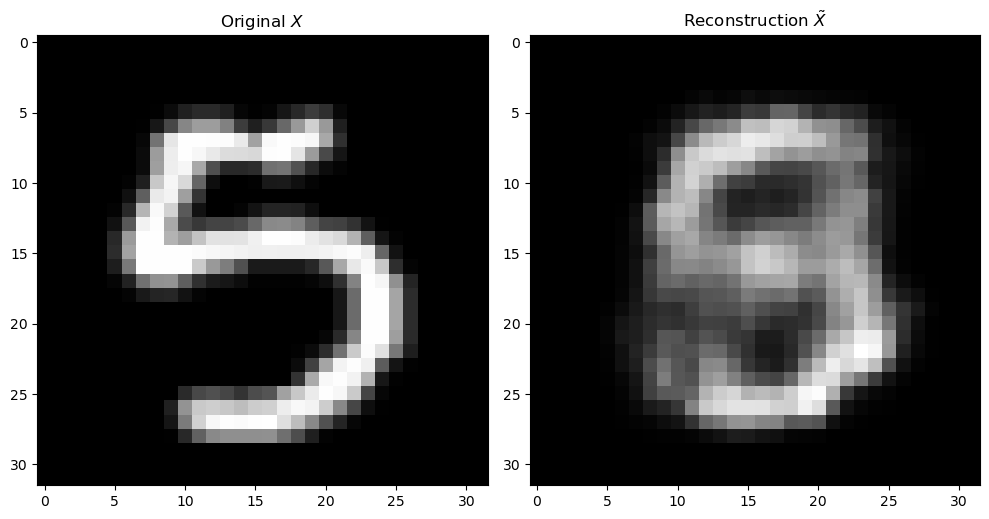

In [34]:
idx = 6

y_pred, _ = generator(X_test[idx][None, :].to(DEVICE))

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))

ax1.set_title(f"Original $X$")
ax2.set_title(r"Reconstruction $\tilde{X}$")

ax1.imshow(X_test[idx][None, :].squeeze(), cmap='gray')
ax2.imshow(F.sigmoid(y_pred).cpu().squeeze().detach(), cmap='gray')
plt.tight_layout()

Another interesting property of a low dimensional latent space is that we can interpolate the latent space to see how certain values for $Z$ get decoded, i.e., get reconstructed. 

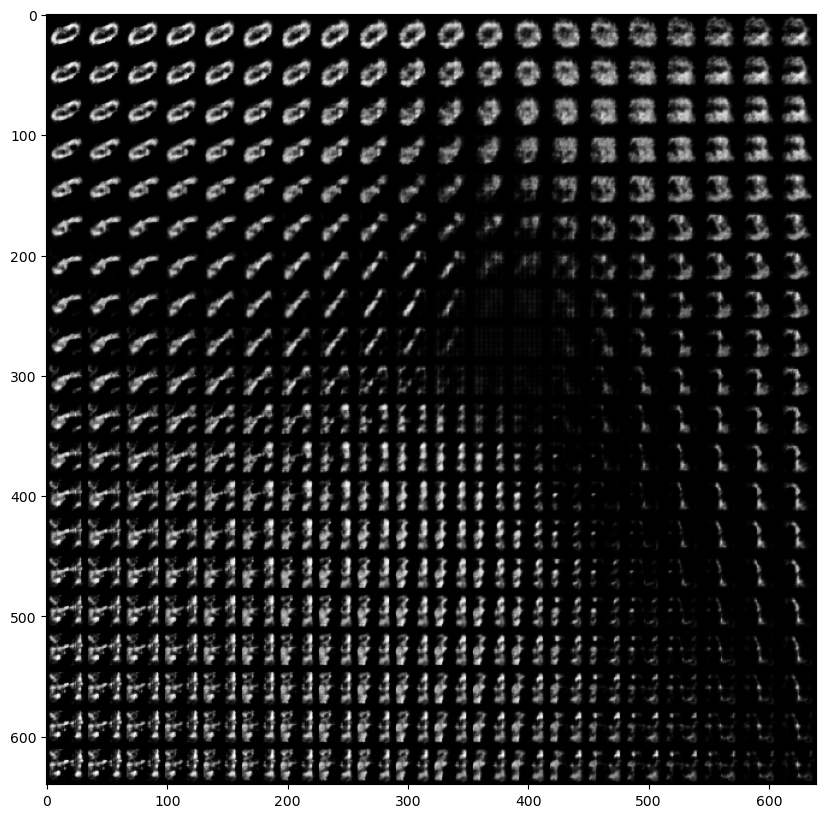

In [35]:
# height, width, ranges for Z 
h = w = 20
z1_range = torch.linspace(-100, 100, h) - 20
z2_range = torch.linspace(-100, 100, w) + 20

# we create a meshgrid of all possible values in z1, z2 ranges
z1, z2 = torch.meshgrid(z1_range, z2_range)
zz = torch.stack([z1, z2], dim=-1).reshape(-1, 2, 1, 1).to(DEVICE)

# predict the Z space
y_preds = F.sigmoid(generator.dec(zz)).squeeze().cpu().detach()
y_preds = y_preds.reshape(h, w, 32, 32).permute(1, 2, 0, 3).reshape(h*32, -1)

plt.figure(figsize=(10, 10))
plt.imshow(y_preds, cmap='gray')

## Variational Auto-Encoder

In the Variational Auto-Encoder, we apply the same idea of reconstructing our input $X$ as $\tilde{X}$ via an encoder and decoder architecture. The only difference is now that we define the latent $Z$ space to be probabilistic. In other words, we put some constrains on the $Z$-space so that we can interpret it as a probability distribution. The nice property of this probabilistic definition is then that we can coherently sample from the distribution, and therefore, generate new reconstructions. 

We may choose the probability distribution $p(Z)$, but in terms of implementation, choosing $p(Z)$ to be Gaussian has many "nice" properties. For one, a Gaussian distribution can be described by two parameters. These are the mean $\mu$ and the variance $\sigma^2$. Our encoder-decoder pipeline is now as follows. We start with some input image $X$ and encode it into a mean $\mu$ and variance $\sigma^2$. We then use these to sample latent $Z \sim \mathcal{N}(\mu, \sigma^2)$. This $Z$ is then decoded into a reconstruction of the input $X$, which we denote by $\tilde{X}$. 

There is one problem with this approach. Since $Z$ is sampled according to a probability distribution, we are unable to backpropagate through $Z$ to adjust the weights of the encoder. In other words, we are stuck! Fortunately, since we decided upon using a Gaussian to represent $p(Z)$, we can reformulate the distribution $\mathcal{N}(\mu, \sigma^2)$ as 

$$
    \mathcal{N}(\mu, \sigma^2) = \mu + \sigma^2 \epsilon
$$
where we let the **randomness** come from an external source $\epsilon \sim \mathcal{N}(0, \textbf{1})$. This way, $\mu$ and $\sigma^2$ are independent of the random process and can be optimized. This is also referred to as the **reparameterization trick**. 

Practically, since $\sigma^2$ must be non-negative, we instead model the logarithm of $\sigma^2$ and exponentiate it when needed. Thus, given an encoder, we get
$$
    [\mu, \log(\sigma^2)] = \text{Encoder}(X)
$$
In other words, our encoder should return both the mean $\mu$ and the logarithm of the variance $\sigma^2$. 

To optimize the VAE, we can again use the Binary Cross-Entropy loss, but now with an added regularization term. We add this additional term to regularize the $Z$-space (or in other words $p(Z)$), as we want it to resemble a simple Gaussian $\mathcal{N}(0, \textbf{1})$ as close as possible. Therefore, this added term should quantify how similar the encoded $Z$-space is to a Gaussian of the form $p(Z) = \mathcal{N}(0, \textbf{1})$. Why? A simple Gaussian $\mathcal{N}(0, \textbf{1})$ makes sampling more simple, and leads to some other simplifications. Of course, we could have chosen any distribution to compare to our $Z$-space distribution. The question now remains: how do you measure the similarity between two probability distributions. One way to do this is by using the so-called Kullback-Leibner (KL) divergence, which is defined as 

$$
    KL(q(\mathbf{Z}) || p(\mathbf{Z})) = E_{Z \sim q}[\log q(\mathbf{Z}) - \log p(\mathbf{Z})]
$$
where $q$ is our encoder distribution and $p$ is our prior distribution which we parameterize as a Gaussian $\mathcal{N}(0, I)$. The KL-divergence term acts as a regularizer to the loss. Fortunately, since we are measuring similarity between two Gaussians via the KL-divergence, it has a very simple form, defined as:

$$
    KL(q(\mathbf{Z} | X; \theta) || p(\mathbf{Z})) = - \frac{1}{2} \sum_{i=1}^d 1 + \log(\sigma_i^2) - \mu_i^2 - \sigma_i^2
$$

where $q(\mathbf{Z} | X; \theta)$ is our encoder, taking $X$ and producing a distribution over $Z$ by using learnable weights $\theta$. The Gaussian parameters that are produced by the encoder, i.e., $\mu$ and $\sigma$ do not necessarily need to be scalars. You can see that in the above analytic expression, we sum over all dimensions of the $\mu$ and $\sigma$ terms. This implies that these values are not scalars, but rather vectors (or lists). What the value of $d$ should be is up to you, and thus a hyperparameter of the model. 

In summary, the loss becomes:

$$
    L = \text{BCELoss}(X, \tilde{X}) + KL(q(\mathbf{Z} | \mathbf{X}; \theta) || p(\mathbf{Z}))
$$

### Kullback-Leibner divergence

It is good to have some intuition on working with Gaussians and measuring their similarity. Again, the KL-divergence is defined as
$$
    Kl(Q(x) || P(x)) = E_{x \sim Q}[\log Q(x) - \log P(x)]
$$
and measures how close the distribution $Q$ is to distribution $P$. Note that this similarity metric is not symmetric. Therefore, $Kl(Q(x) || P(x)) \neq Kl(P(x) || Q(x))$. The KL-divergence can be used as a regularizer to ensure that a learned approximate model $Q$ is encouraged to be close to some prior probability distribution $P$.

KL-divergence from scratch:  177.1358642578125
KL-divergence using pytorch: 177.1358642578125


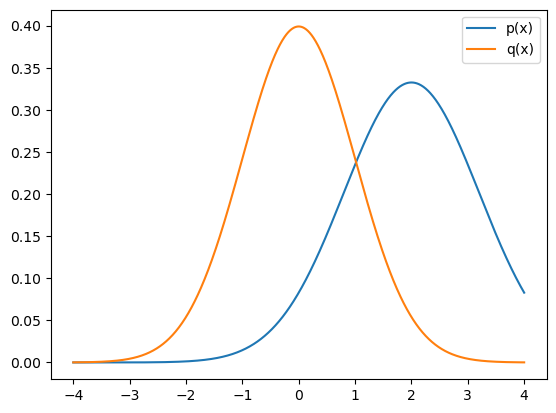

In [2]:
# general formula for a univariate Gaussian
def gaussian(x, mu, sigma):
    return 1/(sigma * (2*torch.pi)**0.5) * torch.exp(-.5 * (x-mu)**2 / sigma**2)

# define a linear range of values between -4 and 4 
x = torch.linspace(-4, 4, 1000)

# define two Gaussians with different parameters
p = gaussian(x, 2, 1.2)
q = gaussian(x, 0, 1)

plt.plot(x, p, label='p(x)')
plt.plot(x, q, label='q(x)')
plt.legend()

# kl(q || p) = sum q(x) (log q(x) - log p(x))
kl = torch.sum(q * (torch.log(q) - torch.log(p)))

# Built-in pytorch function: input is p(x) in log-space and target is q(x)
kl_torch = F.kl_div(torch.log(p), q, reduction='sum')

print(f"KL-divergence from scratch:  {kl}")
print(f"KL-divergence using pytorch: {kl_torch}")

Now, let's define the VAE model. We will simply reuse the `Encoder` and `Decoder` modules from earlier. Note that now our encoder should produce twice the dimensions that the $Z$-space should have, due to the fact that for each dimension in $Z$, there will be two associated values, i.e., $\mu, \sigma$.  

In [36]:
class VAE(nn.Module):
    def __init__(self, z_size=2):
        super().__init__()
        self.z_size = z_size
        self.enc = Encoder(2*z_size)
        self.dec = Decoder(z_size)
    
    def encode(self, X: torch.Tensor):
        h = self.enc(X) # (batch_size, 2*z_dim, 1, 1)
        mu = h[:, :self.z_size].view(-1, self.z_size)       # mean vec mu: (batch_size, z_dim)
        log_var = h[:, self.z_size:].view(-1, self.z_size)  # log variance:(batch_size, z_dim)
        return mu, log_var
    
    def decode(self, mu: torch.Tensor, log_var: torch.Tensor):
        eps = torch.randn(mu.shape[0], self.z_size).to(mu.device) # random eps \sim N(0, I)
        z = mu + torch.exp(0.5 * log_var) * eps
        z = z.reshape(*z.shape, 1, 1) # (batch_size, z_dim, 1, 1)
        y = self.dec(z)
        return y, z
    
    def forward(self, X: torch.Tensor):
        mu, log_var = self.encode(X)
        y, z = self.decode(mu, log_var)
        return y, z, mu, log_var
    
x = torch.randn(16, 1, 32, 32)
g = VAE(z_size=2)
y, z, mu, log_var = g(x)
y.shape, z.shape, mu.shape, log_var.shape

(torch.Size([16, 1, 32, 32]),
 torch.Size([16, 2, 1, 1]),
 torch.Size([16, 2]),
 torch.Size([16, 2]))

### Training VAE

Same as before, load the MNIST dataset and split it accordingly. 

In [37]:
import torchvision
import torchvision.transforms as transforms

transform = transforms.Compose([
    transforms.Resize(32),
    # transforms.Normalize((0.5,), (0.5,)),
    transforms.ToTensor(),
])

train_set = torchvision.datasets.MNIST(root="../datasets", train=True, download=True, transform=transform)

test_val_set = torchvision.datasets.MNIST(root="../datasets", train=False, download=True, transform=transform)
X_test_val, y_test_val = zip(*test_val_set)
X_test_val = torch.stack(X_test_val)
y_test_val = torch.tensor(y_test_val)

test_idx, val_idx = torch.utils.data.random_split(y_test_val, [5000, 5000])

X_test = X_test_val[test_idx.indices]
y_test = y_test_val[test_idx.indices]

X_val = X_test_val[val_idx.indices]
y_val = y_test_val[val_idx.indices]

(train_set.data.shape, train_set.targets.shape, X_test.shape, y_test.shape, X_val.shape, y_val.shape)

(torch.Size([60000, 28, 28]),
 torch.Size([60000]),
 torch.Size([5000, 1, 32, 32]),
 torch.Size([5000]),
 torch.Size([5000, 1, 32, 32]),
 torch.Size([5000]))

We add a new model constant `LAMBDA_REC_ERR`, which refers to the weighting of the reconstruction error, i.e., BCE loss, against the KL-term. If you set `LAMBDA_REC_ERR` to be a high value, it will mean that we regard the BCE loss to be more important than the KL-term. Likewise for setting it to be a very low value, then we regard the KL-term to be more important. 

In [38]:
# Training constants
EPOCHS = 20
BATCH_SIZE = 256
LEARNING_RATE = 0.003
LEARNING_RATE_GAMMA = 0.9

# Model constants
Z_DIM = 2
LAMBDA_REC_ERR = 100

# check for possible GPU usage
DEVICE = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

In [39]:
train_loader = torch.utils.data.DataLoader(train_set, batch_size=BATCH_SIZE, shuffle=True)

generator = VAE(z_size=Z_DIM).to(DEVICE)

optimizer = torch.optim.Adam(generator.parameters(), lr=LEARNING_RATE)
scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=LEARNING_RATE_GAMMA)
criterion = nn.BCEWithLogitsLoss()

train_history = []
val_history = []

for epoch in range(EPOCHS):
    batch_history = []
    for i, (images, _) in enumerate(train_loader):
        images = images.to(DEVICE)
        # predict and compute loss
        preds, _, mu, log_var = generator(images)
        
        # from the original VAE paper
        kl_reg = torch.mean(- 0.5 * torch.sum(1 + log_var - mu.pow(2) - log_var.exp(), dim=1))
        rec_error = LAMBDA_REC_ERR * criterion(preds, images)
        loss = rec_error + kl_reg
        
        batch_history.append(loss.item())
        # optimization step
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    
    # update learning rate
    scheduler.step()
    
    train_history.append(torch.mean(torch.tensor(batch_history)))

    with torch.no_grad():
        preds, _, mu, log_var = generator(X_val.to(DEVICE))
        kl_reg = torch.mean(- 0.5 * torch.sum(1 + log_var - mu.pow(2) - log_var.exp(), dim=1))
        rec_error = LAMBDA_REC_ERR * criterion(preds, X_val.to(DEVICE))
        loss = rec_error + kl_reg
        val_history.append(loss.item())
    
    print(f"epoch {epoch}, train_loss {train_history[-1]}, val_loss {val_history[-1]}")

with torch.no_grad():
    preds, z, mu, sigma = generator(X_test.to(DEVICE))
    kl_reg = torch.mean(- 0.5 * torch.sum(1 + log_var - mu.pow(2) - log_var.exp(), dim=1))
    rec_error = LAMBDA_REC_ERR * criterion(preds, X_test.to(DEVICE))
    loss = rec_error + kl_reg
    print(f"test_loss {loss.item()}")

epoch 0, train_loss 28.204072952270508, val_loss 25.219175338745117
epoch 1, train_loss 24.985078811645508, val_loss 24.699466705322266
epoch 2, train_loss 24.551342010498047, val_loss 24.557641983032227
epoch 3, train_loss 24.42782974243164, val_loss 24.304332733154297
epoch 4, train_loss 24.27899932861328, val_loss 24.190309524536133
epoch 5, train_loss 24.211755752563477, val_loss 24.106969833374023
epoch 6, train_loss 24.148075103759766, val_loss 24.077281951904297
epoch 7, train_loss 24.09600257873535, val_loss 24.136432647705078
epoch 8, train_loss 24.039016723632812, val_loss 23.95207977294922
epoch 9, train_loss 23.997146606445312, val_loss 23.982799530029297
epoch 10, train_loss 23.95607566833496, val_loss 23.93569564819336
epoch 11, train_loss 23.927465438842773, val_loss 23.855642318725586
epoch 12, train_loss 23.881839752197266, val_loss 23.82219123840332
epoch 13, train_loss 23.840396881103516, val_loss 23.822956085205078
epoch 14, train_loss 23.81758689880371, val_loss 23

### Visualize training procedure and latent $Z$-space

Again, since we set the latent $Z$ variable's dimensionality to be two, it is possible to visualize the $Z$-space over the produced values of the test set. Notice how the VAE $Z$-space has no gaps and looks like a bi-variate (2-dimensional) Gaussian distribution. In essence, we could now simply use a Gaussian to generate different kinds of images. 

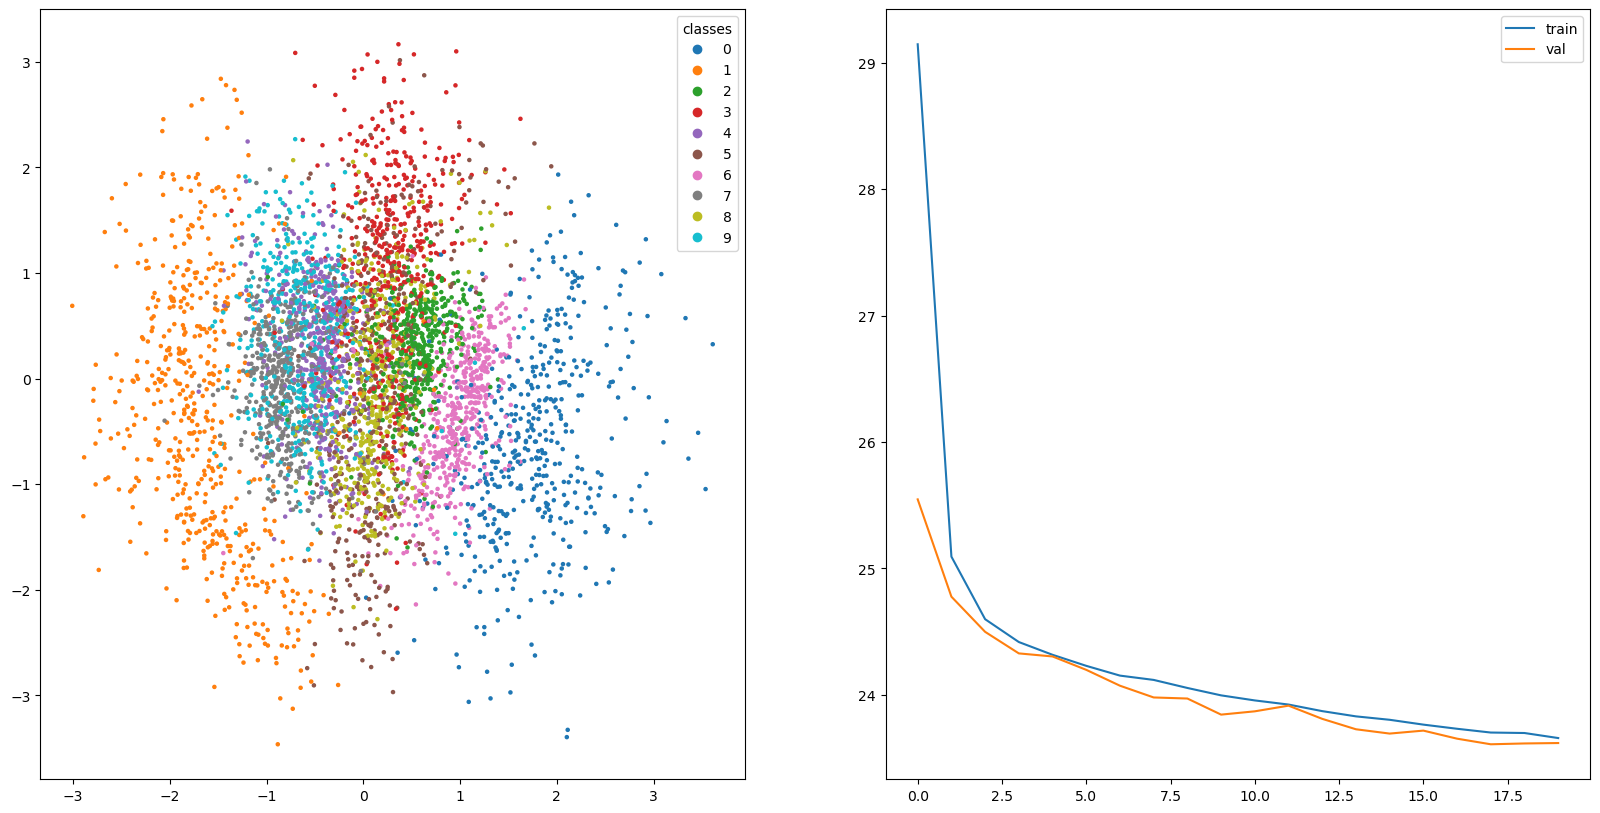

In [9]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 10))

z = z.squeeze().cpu().detach()
sc = ax1.scatter(z[:, 0], z[:, 1], c=y_test, s=5, cmap='tab10')
ax1.legend(*sc.legend_elements(), title='classes')

ax2.plot(train_history, label="train")
ax2.plot(val_history, label="val")
ax2.legend()

### Generating samples

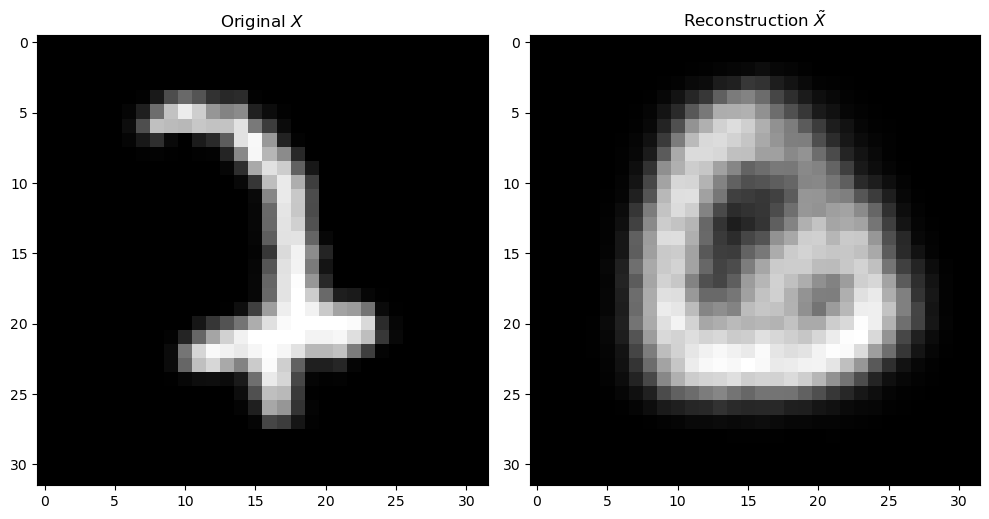

In [21]:
idx = 11
X_sample = X_test[idx].unsqueeze(1).to(DEVICE)

y_pred, _, _, _ = generator(X_sample)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))

ax1.set_title(f"Original $X$")
ax2.set_title(r"Reconstruction $\tilde{X}$")

ax1.imshow(X_test[idx][None, :].squeeze(), cmap='gray')
ax2.imshow(F.sigmoid(y_pred).cpu().squeeze().detach(), cmap='gray')

plt.tight_layout()

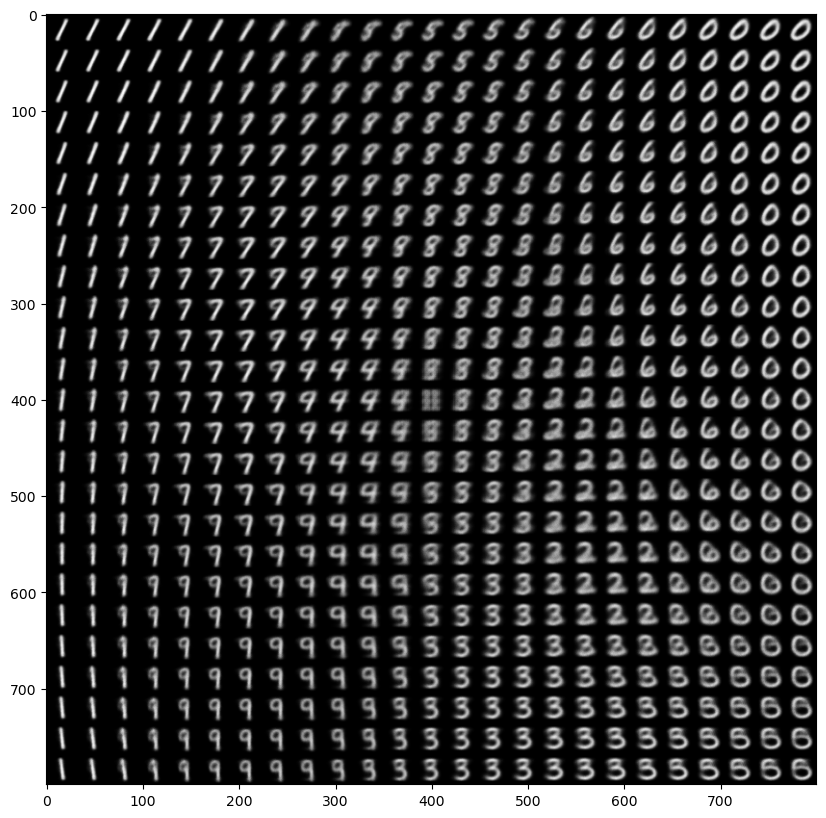

In [18]:
h, w = 25, 25
z1_range = torch.linspace(-75, 75, h)
z2_range = torch.linspace(-75, 75, w)

z1, z2 = torch.meshgrid(z1_range, z2_range)
zz = torch.stack([z1, z2], dim=-1).reshape(-1, 2, 1, 1).to('cuda')

y_preds = F.sigmoid(generator.dec(zz)).squeeze().cpu().detach()
y_preds = y_preds.reshape(h, w, 32, 32).permute(1, 2, 0, 3).reshape(h*32, -1)

plt.figure(figsize=(10, 10))
plt.imshow(y_preds, cmap='gray')

## Another VAE example 

In [41]:
import scipy.io
mat = scipy.io.loadmat('../datasets/olivettifaces.mat')

### train/test/val split

In [42]:
dataset = (mat['faces'].T.reshape(-1, 1, 64, 64))
dataset = np.transpose(dataset, axes=(0, 1, 3, 2)).astype('float32')

dataset = (dataset - np.min(dataset))/np.ptp(dataset)

dataset = torch.tensor(dataset)

mask = np.ones((dataset.shape[0]), bool)
idx = np.random.choice(dataset.shape[0], size=int(0.2 * dataset.shape[0]), replace=False)
mask[idx] = False

X_train = dataset[mask]
X_test = dataset[~mask][:idx.shape[0]//2]
X_val = dataset[~mask][idx.shape[0]//2:]

(X_train.shape, X_test.shape, X_val.shape)

(torch.Size([320, 1, 64, 64]),
 torch.Size([40, 1, 64, 64]),
 torch.Size([40, 1, 64, 64]))

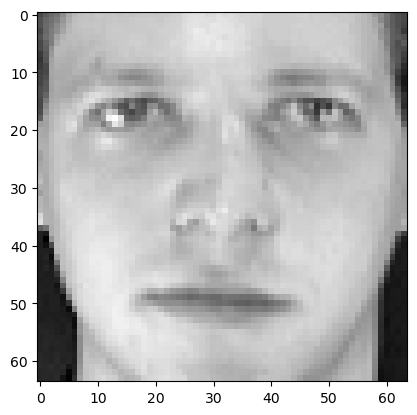

In [45]:
plt.imshow(X_train[0].squeeze(), cmap='gray')

### Add extra encoder/decoder layer for 64 x 64 images

In [47]:
class Encoder64x64(nn.Module):
    def __init__(self, z_size=2):
        super().__init__()
        self.z_size = z_size
        self.net = nn.Sequential(
            # 64 -> 32
            nn.Conv2d(1, 64, kernel_size=3, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(64, affine=True),
            nn.ReLU(inplace=True),
            # 32 -> 16
            nn.Conv2d(64, 128, kernel_size=3, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(128, affine=True),
            nn.ReLU(inplace=True),
            # 16 -> 8
            nn.Conv2d(128, 256, kernel_size=3, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(256, affine=True),
            nn.ReLU(inplace=True),
            # 8 -> 4
            nn.Conv2d(256, 512, kernel_size=3, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(512, affine=True),
            nn.ReLU(inplace=True),
            # 4 -> 1
            nn.Conv2d(512, z_size, kernel_size=3, stride=2, padding=0, bias=False),
        )
    
    def forward(self, X: torch.Tensor):
        return self.net(X)

class Decoder64x64(nn.Module):
    def __init__(self, z_size=2):
        super().__init__()
        self.z_size = z_size
        self.net = nn.Sequential(
            # 1 -> 4
            nn.ConvTranspose2d(z_size, 512, kernel_size=4, stride=1, padding=0, bias=False),
            nn.BatchNorm2d(512, affine=True),
            nn.ReLU(inplace=True),
            # 4 -> 8
            nn.ConvTranspose2d(512, 256, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(256, affine=True),
            nn.ReLU(inplace=True),
            # 8 -> 16
            nn.ConvTranspose2d(256, 128, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(128, affine=True),
            nn.ReLU(inplace=True),
            # 16 -> 32
            nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(64, affine=True),
            nn.ReLU(inplace=True),
            # 32 -> 64
            nn.ConvTranspose2d(64, 1, kernel_size=4, stride=2, padding=1, bias=False),
        )

    def forward(self, X: torch.Tensor):
        return self.net(X)
    
enc = Encoder64x64(2)
dec = Decoder64x64(2)
x = torch.randn(16, 1, 64, 64)
dec(enc(x)).shape

torch.Size([16, 1, 64, 64])

In [48]:
class VAE64x64(nn.Module):
    def __init__(self, z_size=2):
        super().__init__()
        self.z_size = z_size
        self.enc = Encoder64x64(2*z_size)
        self.dec = Decoder64x64(z_size)
    
    def encode(self, X: torch.Tensor):
        h = self.enc(X) # (batch_size, 2*z_dim, 1, 1)
        mu = h[:, :self.z_size].view(-1, self.z_size)       # mean vec mu: (batch_size, z_dim)
        log_var = h[:, self.z_size:].view(-1, self.z_size)  # log variance:(batch_size, z_dim)
        return mu, log_var
    
    def decode(self, mu: torch.Tensor, log_var: torch.Tensor):
        eps = torch.randn(mu.shape[0], self.z_size).to(mu.device) # random eps \sim N(0, I)
        z = mu + torch.exp(0.5 * log_var) * eps
        z = z.reshape(*z.shape, 1, 1) # (batch_size, z_dim, 1, 1)
        y = self.dec(z)
        return y, z
    
    def forward(self, X: torch.Tensor):
        mu, log_var = self.encode(X)
        y, z = self.decode(mu, log_var)
        return y, z, mu, log_var
    
x = torch.randn(16, 1, 64, 64)
g = VAE64x64(z_size=2)
y, z, mu, log_var = g(x)
y.shape, z.shape, mu.shape, log_var.shape

(torch.Size([16, 1, 64, 64]),
 torch.Size([16, 2, 1, 1]),
 torch.Size([16, 2]),
 torch.Size([16, 2]))

### Training procedure

In [49]:
# Training constants
EPOCHS = 100
BATCH_SIZE = 8
LEARNING_RATE = 0.001
LEARNING_RATE_GAMMA = 0.9

# Model constants
Z_DIM = 2
LAMBDA_REC_ERR = 1000

# check for possible GPU usage
DEVICE = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

In [50]:
train_loader = torch.utils.data.DataLoader(X_train, batch_size=BATCH_SIZE, shuffle=True)

generator = VAE64x64(z_size=Z_DIM).to(DEVICE)

optimizer = torch.optim.Adam(generator.parameters(), lr=LEARNING_RATE)
scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=LEARNING_RATE_GAMMA)
criterion = nn.BCEWithLogitsLoss()

train_history = []
val_history = []

for epoch in range(EPOCHS):
    batch_history = []
    for i, images in enumerate(train_loader):
        images = images.to(DEVICE)
        # predict and compute loss
        preds, _, mu, log_var = generator(images)
        
        # from the original VAE paper
        kl_reg = torch.mean(- 0.5 * torch.sum(1 + log_var - mu.pow(2) - log_var.exp(), dim=1))
        rec_error = LAMBDA_REC_ERR * criterion(preds, images)
        loss = rec_error + kl_reg
        
        batch_history.append(loss.item())
        # optimization step
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    
    # update learning rate
    scheduler.step()
    
    train_history.append(torch.mean(torch.tensor(batch_history)))

    with torch.no_grad():
        preds, _, mu, log_var = generator(X_val.to(DEVICE))
        kl_reg = torch.mean(- 0.5 * torch.sum(1 + log_var - mu.pow(2) - log_var.exp(), dim=1))
        rec_error = LAMBDA_REC_ERR * criterion(preds, X_val.to(DEVICE))
        loss = rec_error + kl_reg
        val_history.append(loss.item())
    
    print(f"epoch {epoch}, train_loss {train_history[-1]}, val_loss {val_history[-1]}")

with torch.no_grad():
    preds, z, mu, sigma = generator(X_test.to(DEVICE))
    kl_reg = torch.mean(- 0.5 * torch.sum(1 + log_var - mu.pow(2) - log_var.exp(), dim=1))
    rec_error = LAMBDA_REC_ERR * criterion(preds, X_test.to(DEVICE))
    loss = rec_error + kl_reg
    print(f"test_loss {loss.item()}")

epoch 0, train_loss 713.9287719726562, val_loss 685.2899780273438
epoch 1, train_loss 670.95556640625, val_loss 679.6676635742188
epoch 2, train_loss 664.0548095703125, val_loss 675.514892578125
epoch 3, train_loss 662.06396484375, val_loss 675.4224243164062
epoch 4, train_loss 660.9351806640625, val_loss 674.2564697265625
epoch 5, train_loss 660.7396240234375, val_loss 677.3630981445312
epoch 6, train_loss 659.9632568359375, val_loss 674.2356567382812
epoch 7, train_loss 658.7313232421875, val_loss 675.747314453125
epoch 8, train_loss 658.028564453125, val_loss 676.3711547851562
epoch 9, train_loss 658.5740966796875, val_loss 676.3858642578125
epoch 10, train_loss 658.0572509765625, val_loss 675.4375610351562
epoch 11, train_loss 657.5294189453125, val_loss 675.8783569335938
epoch 12, train_loss 657.3134155273438, val_loss 674.7481689453125
epoch 13, train_loss 657.5206298828125, val_loss 673.5667114257812
epoch 14, train_loss 656.931396484375, val_loss 674.6194458007812
epoch 15, tra

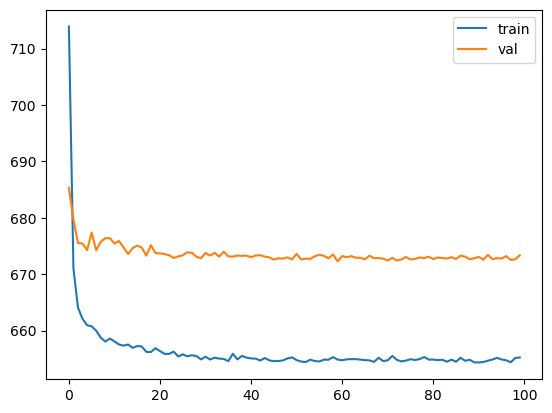

In [51]:
plt.plot(train_history, label="train")
plt.plot(val_history, label="val")
plt.legend()

### Encoding/Decoding specific faces 

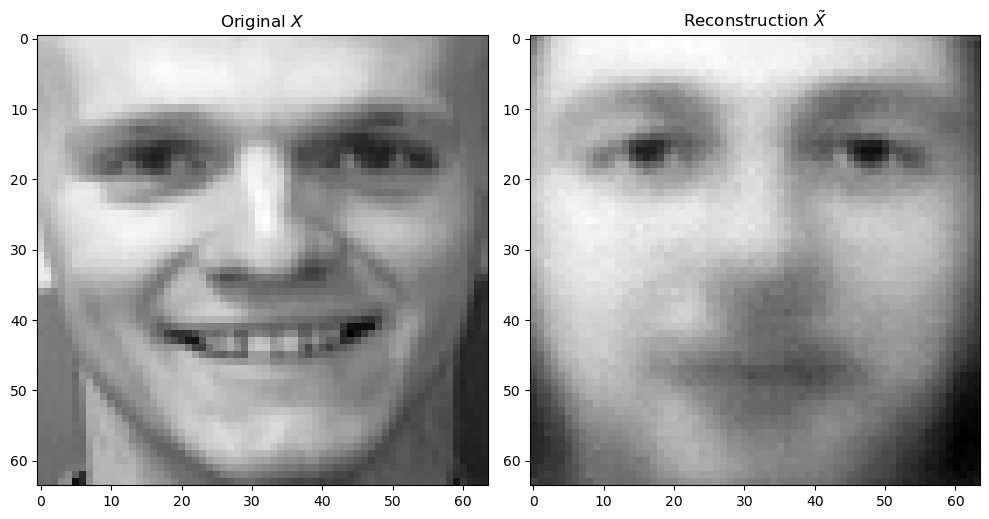

In [57]:
idx = 10
X_sample = X_test[idx].unsqueeze(1).to(DEVICE)

y_pred, _, _, _ = generator(X_sample)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))

ax1.set_title(f"Original $X$")
ax2.set_title(r"Reconstruction $\tilde{X}$")

ax1.imshow(X_test[idx][None, :].squeeze(), cmap='gray')
ax2.imshow(F.sigmoid(y_pred).cpu().squeeze().detach(), cmap='gray')

plt.tight_layout()

### Sampling in the $Z$-space

Text(0, 0.5, '$Z_2$')

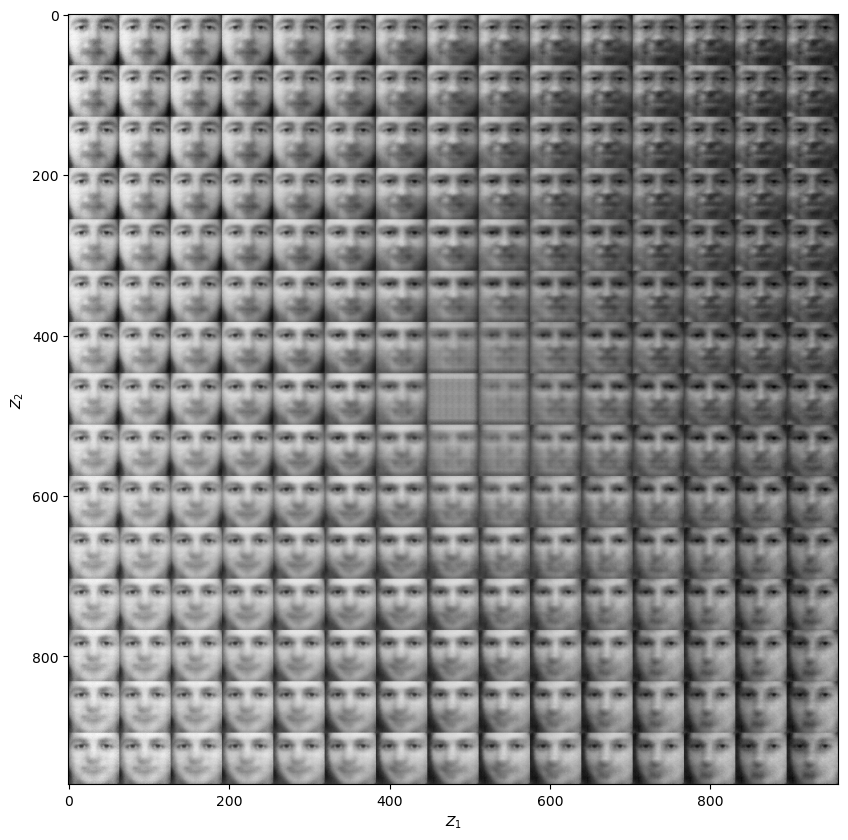

In [55]:
h, w = 15, 15
z1_range = torch.linspace(-1000, 1000, h)
z2_range = torch.linspace(-1000, 1000, w)

z1, z2 = torch.meshgrid(z1_range, z2_range)
zz = torch.stack([z1, z2], dim=-1).reshape(-1, 2, 1, 1).to('cuda')

y_preds = F.sigmoid(generator.dec(zz)).squeeze().cpu().detach()
y_preds = y_preds.reshape(h, w, 64, 64).permute(1, 2, 0, 3).reshape(h*64, -1)

plt.figure(figsize=(10, 10))
plt.imshow(y_preds, cmap='gray')
plt.axis('image')
plt.xlabel(r'$Z_1$')
plt.ylabel(r'$Z_2$')

# plt.savefig("../images/manifolds/faces.svg", dpi=300)

### Random sampling if $|Z| > 2$

In [ ]:
# h, w = 15, 15
# z_vecs = torch.randn(h*w, Z_SIZE, 1, 1).to('cuda')
# 
# y_preds = F.sigmoid(generator.dec(z_vecs)).squeeze().cpu().detach()
# y_preds = y_preds.reshape(h, w, 64, 64).permute(1, 2, 0, 3).reshape(h*64, -1)
# 
# plt.figure(figsize=(10, 10))
# plt.imshow(y_preds, cmap='gray')

## Generative Adverserial Networks (GAN)

In GANs, we employ two networks, which get optimized side-by-side. One is the **generator** network whose job it is to generate images based on random (often Gaussian) noise. The second is the **discriminator** network whose job it is to distinguish (or discriminate) between fake generated images and actual images from the training set. Therefore, the generator can be modeled as
$$
    \tilde{X} = \text{Generator}(Z) \qquad \text{where } Z \sim \mathcal{N}(0, \textbf{1})
$$
or in other words, given a randomly sampled $Z$ from a Gaussian distribution, the generator gives us a fake image $\tilde{X}$. Then the discriminator can be modeled as
$$
    \hat{y} = \text{Discriminator}(X)
$$
or in other words, provided that we give the discriminator an image, $X$, it will give us the probability $\hat{y}$ that $X$ is a real training example rather than a fake sample generated from the generator. Both networks are adversaries to each other, competing to out-do each other in their respective tasks. We can also formulate the learning process in adversarial networks as a zero-sum game, in which a function $v(\text{generator}, \text{discriminator})$ determines the payoff to the discriminator. The generator receives $-v(\text{generator}, \text{discriminator})$ as its own payoff. Notice that the sum of both payoff is always zero, i.e., it is a zero-sum game. During learning, each player attempts to maximize its own payoff. 

This process drives the discriminator to attempt to learn to correctly classify samples as real or fake. Simultaneously, the generator attempts to fool the discriminator into believing its samples are real. At convergence, we hope to see that the generator's samples are indistinguishable from real samples, and that on average the discriminator outputs high probabilities, as it is unsure whether images are real or fake. The discriminator can then be discarded, and we are left with a coherent generator.

In practice, it is quite difficult to use this zero-sum game approach to model the learning process. The reason being that often good local minima in the loss are not reached, but rather so-called saddle points are reached. These are locations in the loss landscape where it is a local minima for one player and a local maxima for the other player. In other words, it is an equillibrium where both players are at stalemate, meaning that optimizing the loss for one player will have the reverse effect for the other player. 

The best-performing formulation of the GAN game formulates a different aim for the generator. The generator aims to increase the log-probability that the discriminator makes a mistake, rather than aiming to decrease the log-probability that the discriminator makes a correct prediction. 

### Generator and Discriminator modules

Notice that the generator module below has a similar structure to that of the decoder module in the Auto-Encoder setup. The discriminator module looks similar to the encoder module, but behaves in a different way, as it will output a single value indicating the probability that the input image is a real image. 

In [58]:
class Generator(nn.Module):
    def __init__(self, z_size=2):
        super().__init__()
        self.z_size = z_size
        self.net = nn.Sequential(
            # 1 -> 4
            nn.ConvTranspose2d(z_size, 256, kernel_size=4, stride=1, padding=0, bias=False),
            nn.BatchNorm2d(256, affine=True),
            nn.ReLU(inplace=True),
            # 4 -> 8
            nn.ConvTranspose2d(256, 128, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(128, affine=True),
            nn.ReLU(inplace=True),
            # 8 -> 16
            nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(64, affine=True),
            nn.ReLU(inplace=True),
            # 16 -> 32
            nn.ConvTranspose2d(64, 1, kernel_size=4, stride=2, padding=1, bias=False),
        )

    def forward(self, X: torch.Tensor):
        return self.net(X)

class Discriminator(nn.Module):
    def __init__(self):
        super().__init__()
        self.net = nn.Sequential(
            # 32 -> 16
            nn.Conv2d(1, 64, kernel_size=3, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(64, affine=True),
            nn.ReLU(inplace=True),
            # 16 -> 8
            nn.Conv2d(64, 128, kernel_size=3, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(128, affine=True),
            nn.ReLU(inplace=True),
            # 8 -> 4
            nn.Conv2d(128, 256, kernel_size=3, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(256, affine=True),
            nn.ReLU(inplace=True),
            # 4 -> 1
            nn.Conv2d(256, 1, kernel_size=3, stride=2, padding=0, bias=False),
            nn.Flatten(),
            nn.Sigmoid()
        )
    
    def forward(self, X: torch.Tensor):
        return self.net(X)

# test
gen = Generator(z_size=2).to(DEVICE)
dis = Discriminator().to(DEVICE)
z = torch.randn(32, 2, 1, 1).to(DEVICE)
gen(z).shape, dis(gen(z)).shape

(torch.Size([32, 1, 32, 32]), torch.Size([32, 1]))

### Prepare dataset

In [59]:
import torchvision
import torchvision.transforms as transforms

transform = transforms.Compose([
    transforms.Resize(32),
    transforms.ToTensor(),
])

train_set = torchvision.datasets.MNIST(root="../datasets", train=True, download=True, transform=transform)

test_val_set = torchvision.datasets.MNIST(root="../datasets", train=False, download=True, transform=transform)
X_test_val, y_test_val = zip(*test_val_set)
X_test_val = torch.stack(X_test_val)
y_test_val = torch.tensor(y_test_val)

test_idx, val_idx = torch.utils.data.random_split(y_test_val, [5000, 5000])

X_test = X_test_val[test_idx.indices]
y_test = y_test_val[test_idx.indices]

X_val = X_test_val[val_idx.indices]
y_val = y_test_val[val_idx.indices]

(train_set.data.shape, train_set.targets.shape, X_test.shape, y_test.shape, X_val.shape, y_val.shape)

(torch.Size([60000, 28, 28]),
 torch.Size([60000]),
 torch.Size([5000, 1, 32, 32]),
 torch.Size([5000]),
 torch.Size([5000, 1, 32, 32]),
 torch.Size([5000]))

### Training loss and step function

In [88]:
# Training constants
EPOCHS = 50
BATCH_SIZE = 128
LEARNING_RATE_GEN = 0.001
LEARNING_RATE_DIS = 0.00003
LEARNING_RATE_GAMMA_GEN = 0.95
LEARNING_RATE_GAMMA_DIS = 0.95

# Model constants
Z_DIM = 2

# check for possible GPU usage
DEVICE = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

In [89]:
def step(images, D, G, optimizer_dis, optimizer_gen, train=True):

    batch_size = images.shape[0]

    # tensor of 1's and 0's to compare to probabilities produced by 
    # discriminator for both real and fake images, respectively
    ones = torch.ones((batch_size, 1), device=DEVICE)
    zeros = torch.zeros((batch_size, 1), device=DEVICE)

    images = images.to(DEVICE)
    
    # generate random Gaussian noise with shape (batch_size, Z_dim, 1, 1)
    z = torch.randn(batch_size, Z_DIM, 1, 1, device=DEVICE)
    # generate fake images based on z
    fake_images = G(z)
    # discriminate fake images and real images
    y_pred = D(fake_images.detach())
    y_true = D(images)
    
    # discriminator loss consists of two BCE terms:
    # 1. BCE(y_true, 1) encourages model to give high probability to real images
    # 2. BCE(y_fake, 0) encourages model to give low probability to fake images
    loss_dis = F.binary_cross_entropy(y_true, ones) + F.binary_cross_entropy(y_pred, zeros)
    if train:
        optimizer_dis.zero_grad()
        loss_dis.backward()
        optimizer_dis.step()
    
    # recompute y_pred since discriminator potentially changed, due to backprop
    y_pred = D(fake_images)
    # generator loss is a single BCE term between y_pred and 1's
    # so that the predictions of fake images are as close as possible to real image predictions
    loss_gen = F.binary_cross_entropy(y_pred, ones)
    if train:
        optimizer_gen.zero_grad()
        loss_gen.backward()
        optimizer_gen.step()
    
    return loss_dis.item(), loss_gen.item(), z


### Training procedure

In [90]:
train_loader = torch.utils.data.DataLoader(train_set, batch_size=BATCH_SIZE, shuffle=True)

generator = Generator(z_size=Z_DIM).to(DEVICE)
discriminator = Discriminator().to(DEVICE)

optimizer_gen = torch.optim.Adam(generator.parameters(), lr=LEARNING_RATE_GEN)
optimizer_dis = torch.optim.Adam(discriminator.parameters(), lr=LEARNING_RATE_DIS)

scheduler_gen = torch.optim.lr_scheduler.ExponentialLR(optimizer_gen, gamma=LEARNING_RATE_GAMMA_GEN)
scheduler_dis = torch.optim.lr_scheduler.ExponentialLR(optimizer_dis, gamma=LEARNING_RATE_GAMMA_DIS)

train_history = []
val_history = []

for epoch in range(EPOCHS):
    batch_history = []
    for i, (images, _) in enumerate(train_loader):
        
        loss_dis, loss_gen, _ = step(images, discriminator, generator, optimizer_dis, optimizer_gen)
        batch_history.append([loss_dis, loss_gen])
        
    # update learning rate
    scheduler_gen.step()
    scheduler_dis.step()
    
    mean_loss_dis, mean_loss_gen = np.mean(batch_history, axis=0)
    train_history.append([mean_loss_dis, mean_loss_gen])

    with torch.no_grad():
        loss_dis, loss_gen, _ = step(X_val.to(DEVICE), discriminator, generator, optimizer_dis, optimizer_gen, train=False)
        val_history.append([loss_dis, loss_gen])
    
    print(f"epoch {epoch}, train_loss {train_history[-1]}, val_loss {val_history[-1]}")

with torch.no_grad():
    loss_dis, loss_gen, z = step(X_test.to(DEVICE), discriminator, generator, optimizer_dis, optimizer_gen, train=False)
    print(f"test_loss: {loss_dis}, {loss_gen}")

epoch 0, train_loss [2.2661373328044214, 0.40510480218668227], val_loss [1.593240737915039, 0.59418785572052]
epoch 1, train_loss [1.4987914435136547, 0.6443052812934176], val_loss [1.3651344776153564, 0.6757392287254333]
epoch 2, train_loss [1.4140876989120614, 0.6855063757408403], val_loss [1.3521668910980225, 0.6359485983848572]
epoch 3, train_loss [1.3794185167182482, 0.7077910455305185], val_loss [1.3071424961090088, 0.7565457820892334]
epoch 4, train_loss [1.3208193130838846, 0.7504736899312879], val_loss [1.3546640872955322, 0.7229059338569641]
epoch 5, train_loss [1.2993643687986363, 0.7684721684913391], val_loss [1.3039273023605347, 0.7405603528022766]
epoch 6, train_loss [1.2064000238487715, 0.8491086192222547], val_loss [1.1575164794921875, 0.8418565988540649]
epoch 7, train_loss [1.0929460972865253, 0.9456222452588682], val_loss [1.0455927848815918, 0.9872238039970398]
epoch 8, train_loss [0.9671193746361397, 1.0646724850892513], val_loss [0.8747493624687195, 1.114572882652

### Visualize training progress 

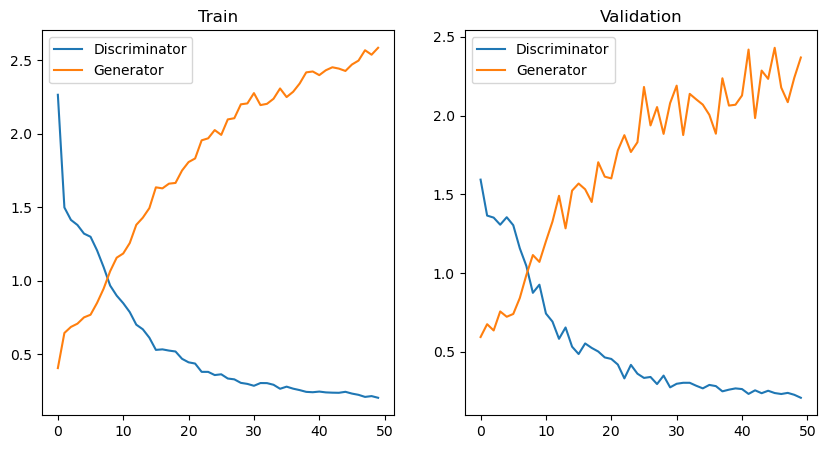

In [91]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))

np_train_history = np.array(train_history)
np_val_history = np.array(val_history)

ax1.plot(np_train_history[:, 0], label="Discriminator")
ax1.plot(np_train_history[:, 1], label="Generator")
ax1.set_title("Train")
ax1.legend()

ax2.plot(np_val_history[:, 0], label="Discriminator")
ax2.plot(np_val_history[:, 1], label="Generator")
ax2.set_title("Validation")
ax2.legend()

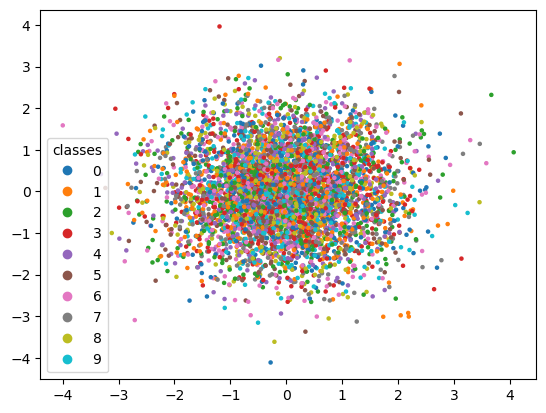

In [92]:
z = z.squeeze().cpu().detach()
sc = plt.scatter(z[:, 0], z[:, 1], c=y_test, s=5, cmap='tab10')
plt.legend(*sc.legend_elements(), title='classes')

### Sample from Z-space

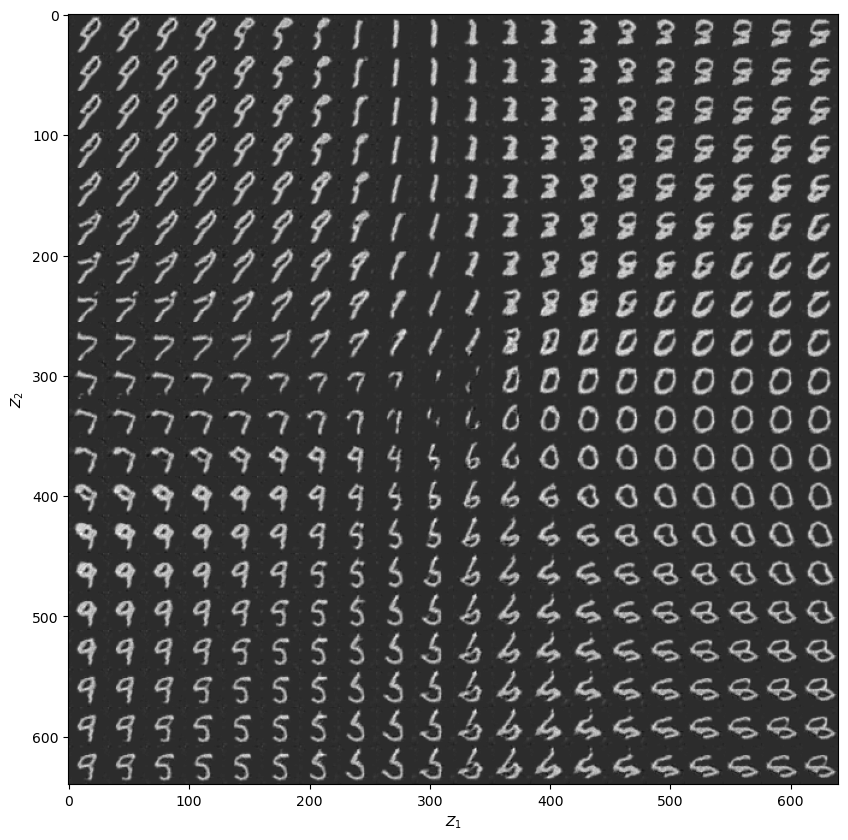

In [93]:
IMG_SIZE = 32

h, w = 20, 20
z1_range = torch.linspace(-1000, 1000, h)
z2_range = torch.linspace(-1000, 1000, w)

z1, z2 = torch.meshgrid(z1_range, z2_range)
zz = torch.stack([z1, z2], dim=-1).reshape(-1, 2, 1, 1).to('cuda')

y_preds = generator(zz).squeeze().cpu().detach()
y_preds = y_preds.reshape(h, w, IMG_SIZE, IMG_SIZE).permute(1, 2, 0, 3).reshape(h*IMG_SIZE, -1)

plt.figure(figsize=(10, 10))
plt.imshow(y_preds, cmap='gray')
plt.axis('image')
plt.xlabel(r'$Z_1$')
plt.ylabel(r'$Z_2$')

plt.show()
# plt.savefig("../images/manifolds/faces.svg", dpi=300)

## Another GAN example

In [94]:
import scipy.io
mat = scipy.io.loadmat('../datasets/olivettifaces.mat')

### train/test/val split

In [95]:
dataset = (mat['faces'].T.reshape(-1, 1, 64, 64))
dataset = np.transpose(dataset, axes=(0, 1, 3, 2)).astype('float32')

dataset = (dataset - np.min(dataset))/np.ptp(dataset)

dataset = torch.tensor(dataset)

mask = np.ones((dataset.shape[0]), bool)
idx = np.random.choice(dataset.shape[0], size=int(0.2 * dataset.shape[0]), replace=False)
mask[idx] = False

X_train = dataset[mask]
X_test = dataset[~mask][:idx.shape[0]//2]
X_val = dataset[~mask][idx.shape[0]//2:]

(X_train.shape, X_test.shape, X_val.shape)

(torch.Size([320, 1, 64, 64]),
 torch.Size([40, 1, 64, 64]),
 torch.Size([40, 1, 64, 64]))

### 64x64 Generator and discriminator

In [96]:
class Generator64x64(nn.Module):
    def __init__(self, z_size=2):
        super().__init__()
        self.z_size = z_size
        self.net = nn.Sequential(
            # 1 -> 4
            nn.ConvTranspose2d(z_size, 512, kernel_size=4, stride=1, padding=0, bias=False),
            nn.BatchNorm2d(512, affine=True),
            nn.ReLU(inplace=True),
            # 4 -> 8
            nn.ConvTranspose2d(512, 256, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(256, affine=True),
            nn.ReLU(inplace=True),
            # 8 -> 16
            nn.ConvTranspose2d(256, 128, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(128, affine=True),
            nn.ReLU(inplace=True),
            # 16 -> 32
            nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(64, affine=True),
            nn.ReLU(inplace=True),
            # 32 -> 64
            nn.ConvTranspose2d(64, 1, kernel_size=4, stride=2, padding=1, bias=False),
        )

    def forward(self, X: torch.Tensor):
        return self.net(X)

class Discriminator64x64(nn.Module):
    def __init__(self):
        super().__init__()
        self.net = nn.Sequential(
            # 64 -> 32
            nn.Conv2d(1, 64, kernel_size=3, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(64, affine=True),
            nn.ReLU(inplace=True),
            # 32 -> 16
            nn.Conv2d(64, 128, kernel_size=3, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(128, affine=True),
            nn.ReLU(inplace=True),
            # 16 -> 8
            nn.Conv2d(128, 256, kernel_size=3, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(256, affine=True),
            nn.ReLU(inplace=True),
            # 8 -> 4
            nn.Conv2d(256, 512, kernel_size=3, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(512, affine=True),
            nn.ReLU(inplace=True),
            # 4 -> 1
            nn.Conv2d(512, 1, kernel_size=3, stride=2, padding=0, bias=False),
            nn.Flatten(),
            nn.Sigmoid()
        )
    
    def forward(self, X: torch.Tensor):
        return self.net(X)

gen = Generator64x64(z_size=2).to('cuda')
dis = Discriminator64x64().to('cuda')
z = torch.randn(32, 2, 1, 1).to('cuda')
gen(z).shape, dis(gen(z)).shape

(torch.Size([32, 1, 64, 64]), torch.Size([32, 1]))

### Training procedure

In [99]:
# Training constants
EPOCHS = 100
BATCH_SIZE = 16
LEARNING_RATE_GEN = 0.01
LEARNING_RATE_DIS = 0.003
LEARNING_RATE_GAMMA_GEN = 0.95
LEARNING_RATE_GAMMA_DIS = 0.95

# Model constants
Z_DIM = 2

# check for possible GPU usage
DEVICE = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

In [100]:
train_loader = torch.utils.data.DataLoader(X_train, batch_size=BATCH_SIZE, shuffle=True)

generator = Generator64x64(z_size=Z_DIM).to(DEVICE)
discriminator = Discriminator64x64().to(DEVICE)

optimizer_gen = torch.optim.Adam(generator.parameters(), lr=LEARNING_RATE_GEN)
optimizer_dis = torch.optim.Adam(discriminator.parameters(), lr=LEARNING_RATE_DIS)

scheduler_gen = torch.optim.lr_scheduler.ExponentialLR(optimizer_gen, gamma=LEARNING_RATE_GAMMA_GEN)
scheduler_dis = torch.optim.lr_scheduler.ExponentialLR(optimizer_dis, gamma=LEARNING_RATE_GAMMA_DIS)

train_history = []
val_history = []

for epoch in range(EPOCHS):
    batch_history = []
    for i, images in enumerate(train_loader):
        
        loss_dis, loss_gen, _ = step(images, discriminator, generator, optimizer_dis, optimizer_gen)
        batch_history.append([loss_dis, loss_gen])
        
    # update learning rate
    scheduler_gen.step()
    scheduler_dis.step()
    
    mean_loss_dis, mean_loss_gen = np.mean(batch_history, axis=0)
    train_history.append([mean_loss_dis, mean_loss_gen])

    with torch.no_grad():
        loss_dis, loss_gen, _ = step(X_val.to(DEVICE), discriminator, generator, optimizer_dis, optimizer_gen, train=False)
        val_history.append([loss_dis, loss_gen])
    
    print(f"epoch {epoch}, train_loss {train_history[-1]}, val_loss {val_history[-1]}")

with torch.no_grad():
    loss_dis, loss_gen, z = step(X_test.to(DEVICE), discriminator, generator, optimizer_dis, optimizer_gen, train=False)
    print(f"test_loss: {loss_dis}, {loss_gen}")

epoch 0, train_loss [0.09588859187206253, 7.666001987457276], val_loss [0.001267294748686254, 7.7674407958984375]
epoch 1, train_loss [0.013511624807142653, 8.849981307983398], val_loss [0.003793067065998912, 6.5700249671936035]
epoch 2, train_loss [0.6466995658993255, 12.810584524273873], val_loss [0.004306274466216564, 5.673748970031738]
epoch 3, train_loss [0.10642637993441895, 6.114848518371582], val_loss [0.010623998939990997, 5.9030961990356445]
epoch 4, train_loss [0.20506602751120226, 15.811245036125182], val_loss [0.00010500330972718075, 32.49039840698242]
epoch 5, train_loss [0.04760598308951103, 16.51701979637146], val_loss [0.04831896349787712, 6.12074089050293]
epoch 6, train_loss [0.28258614070946353, 15.14988956451416], val_loss [0.39855092763900757, 4.028800010681152]
epoch 7, train_loss [0.29134119726677454, 16.894179821014404], val_loss [0.3224039077758789, 19.719778060913086]
epoch 8, train_loss [0.25961601153831, 13.340060138702393], val_loss [0.0020528752356767654,

### Visualize training progress 

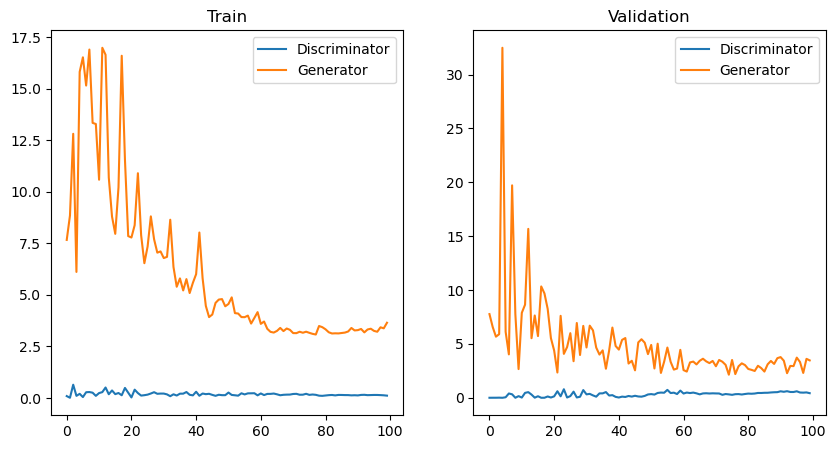

In [101]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))

np_train_history = np.array(train_history)
np_val_history = np.array(val_history)

ax1.plot(np_train_history[:, 0], label="Discriminator")
ax1.plot(np_train_history[:, 1], label="Generator")
ax1.set_title("Train")
ax1.legend()

ax2.plot(np_val_history[:, 0], label="Discriminator")
ax2.plot(np_val_history[:, 1], label="Generator")
ax2.set_title("Validation")
ax2.legend()

### Sample from $Z$-space

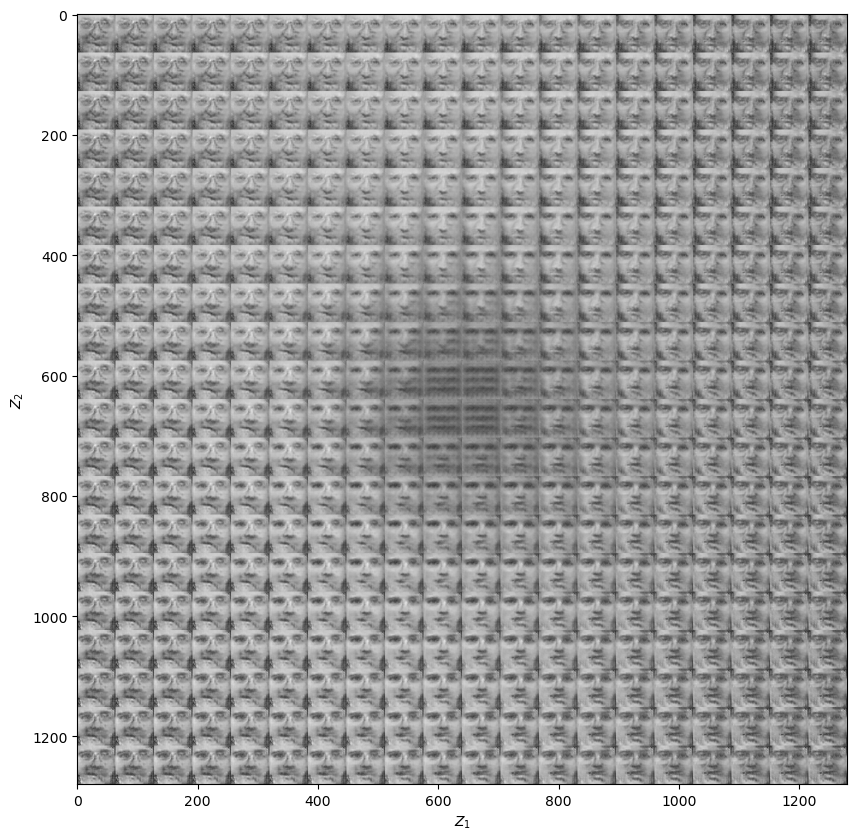

In [102]:
IMG_SIZE = 64

h, w = 20, 20
z1_range = torch.linspace(-1000, 1000, h)
z2_range = torch.linspace(-1000, 1000, w)

z1, z2 = torch.meshgrid(z1_range, z2_range)
zz = torch.stack([z1, z2], dim=-1).reshape(-1, 2, 1, 1).to('cuda')

y_preds = generator(zz).squeeze().cpu().detach()
y_preds = y_preds.reshape(h, w, IMG_SIZE, IMG_SIZE).permute(1, 2, 0, 3).reshape(h*IMG_SIZE, -1)

plt.figure(figsize=(10, 10))
plt.imshow(y_preds, cmap='gray')
plt.axis('image')
plt.xlabel(r'$Z_1$')
plt.ylabel(r'$Z_2$')

plt.show()
# plt.savefig("../images/manifolds/faces.svg", dpi=300)

### Random sampling when $|Z| > 2$

In [103]:
# h, w = 10, 10
# z_vecs = torch.randn(h*w, Z_DIM, 1, 1).to('cuda')

# y_preds = generator(z_vecs).squeeze().cpu().detach()
# y_preds = y_preds.reshape(h, w, 64, 64).permute(1, 2, 0, 3).reshape(h*64, -1)

# plt.figure(figsize=(10, 10))
# plt.imshow(y_preds, cmap='gray')